# Simulation using Concord

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scanpy as sc
import time
from pathlib import Path
import torch
import concord as ccd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib as mpl

from matplotlib import font_manager, rcParams
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.fonttype'] = 42

In [3]:
proj_name = "simulation_loop_and_branch"
save_dir = f"../save/dev_{proj_name}-{time.strftime('%b%d')}/"
save_dir = Path(save_dir)
save_dir.mkdir(parents=True, exist_ok=True)

data_dir = f"../data/{proj_name}/"
data_dir = Path(data_dir)
data_dir.mkdir(parents=True, exist_ok=True)
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(device)
seed = 0
ccd.ul.set_seed(seed)

file_suffix = f"{time.strftime('%b%d-%H%M')}"
file_suffix

cpu


'Jun12-1338'

In [13]:
# ─────────────────────────────  imports  ─────────────────────────────
import numpy as np
import pandas as pd
import anndata as ad

# the refactored simulator & config classes
from concord.utils.simulation import (
    Simulation,
    SimConfig,
    TrajectoryConfig,
    TreeConfig,
    BatchConfig,
)
from concord.utils.anndata_utils import ordered_concat   # same helper you used

# ───────────────────────────  constants  ────────────────────────────
# trajectory settings
N_CELLS_TRAJ       = 1_000
N_GENES_TRAJ       = 300
TRAJ_PROGRAM_NUM   = 4
LOOP_PROGRAM_IDX   = 0          # loop back to the 1st program
MEAN_EXPRESSION    = 20

# tree settings
N_CELLS_TREE       = 500
N_GENES_TREE   = 300         # *new* genes added by branches
TREE_BRANCH_FACTOR = 2
TREE_DEPTH         = 2
TREE_PROG_DECAY    = 1.0

GLOBAL_NOISE_DISP  = 10         # σ for the last “counts-like” layer

# ────────────────── 1) looping-trajectory  ──────────────────────────
sim_cfg_traj = SimConfig(
    n_cells = N_CELLS_TRAJ,
    n_genes = N_GENES_TRAJ,
    seed    = 42,
    non_neg = True,
    to_int  = True,
)

traj_cfg = TrajectoryConfig(
    program_num              = TRAJ_PROGRAM_NUM,
    loop_to                  = [LOOP_PROGRAM_IDX],
    cell_block_size_ratio    = 0.5,
    program_structure        = "linear_bidirectional",
    program_on_time_fraction = 0.10,
    distribution             = "normal",
    level                    = MEAN_EXPRESSION,
    dispersion               = 0,          # deterministic backbone
    min_level                = 0,
)

# no real batch effects – we still need a BatchConfig object, so use a dummy
dummy_batch = BatchConfig(n_batches=1)

sim_traj   = Simulation(sim_cfg_traj, traj_cfg, dummy_batch)
adata_traj = sim_traj.simulate_state()
adata_traj.obs["structure"] = "trajectory"

# ───────────── 2) pick genes to inherit into the tree  ──────────────
prog_size       = N_GENES_TRAJ // TRAJ_PROGRAM_NUM + (N_GENES_TRAJ % TRAJ_PROGRAM_NUM > 0)
start, end      = LOOP_PROGRAM_IDX * prog_size, min((LOOP_PROGRAM_IDX + 1) * prog_size, N_GENES_TRAJ)
genes_inherited = adata_traj.var_names[start:end].tolist()

# ───────────────────── 3) binary tree  ──────────────────────────────
sim_cfg_tree = SimConfig(
    n_cells = N_CELLS_TREE,
    n_genes = N_GENES_TREE,      # only the *new* genes
    seed    = 123,
    non_neg = True,
    to_int  = True,
)

tree_cfg = TreeConfig(
    branching_factor          = TREE_BRANCH_FACTOR,
    depth                     = TREE_DEPTH,
    program_decay             = TREE_PROG_DECAY,
    program_structure         = "linear_increasing",
    program_on_time_fraction  = 0.10,
    distribution              = "normal",
    level                     = MEAN_EXPRESSION,
    dispersion                = 0,
    min_level                 = 0,
    noise_in_block            = False,          # match your old flag
    initial_inherited_genes   = genes_inherited,
)

sim_tree   = Simulation(sim_cfg_tree, tree_cfg, dummy_batch)
adata_tree = sim_tree.simulate_state()
adata_tree.obs["structure"] = "tree"

# ────────────────── 4) concatenate & add global noise  ──────────────
adata_state = ordered_concat(                   # keeps original cell order
    [adata_traj, adata_tree],
    join="outer",
    label="origin",            # trajectory / tree
    index_unique=None,
)

adata       = adata_state.copy()
adata.X     = (
    adata_state.X
    + Simulation.simulate_distribution(
        "normal",
        adata_state.X,
        GLOBAL_NOISE_DISP,
        nonzero_only=True,
    )
)
adata.X[adata.X < 0] = 0
adata.layers["counts"] = adata.X.copy()

print("Simulation complete!")
print(adata)


Simulation complete!
AnnData object with n_obs × n_vars = 1875 × 825
    obs: 'time', 'structure', 'branch', 'depth', 'origin'
    layers: 'no_noise', 'wt_noise', 'counts'


In [14]:
# PCA on no_noise data
LATENT_DIM = 20
sc.pp.pca(adata_state, use_highly_variable=False, n_comps=LATENT_DIM, zero_center=True, svd_solver='arpack', random_state=seed)
adata.obsm['PCA_no_noise'] = adata_state.obsm['X_pca']
# PCA on noise data
sc.pp.pca(adata, use_highly_variable=False, n_comps=LATENT_DIM, zero_center=True, svd_solver='arpack', random_state=seed)
adata.obsm['PCA_noise'] = adata.obsm['X_pca']

### Concord

In [15]:
concord_args = {
    'adata': adata,
    'input_feature': None, 
    'domain_key': None,
    'p_intra_knn':0.3,
    'latent_dim': LATENT_DIM, # latent dimension size
    'seed': seed, # random seed
    'verbose': False, # print training progress
    'device': device, # device to run on
    'save_dir': save_dir # directory to save model checkpoints
}
cur_ccd = ccd.Concord(**concord_args)

# Encode data, saving the latent embedding in adata.obsm['Concord']
output_key = 'Concord'
cur_ccd.encode_adata(input_layer_key='X', output_key=output_key, preprocess=False)

Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Concord - WARNING - domain/batch information not found, all samples will be treated as from single domain/batch.


FAISS not found. Using sklearn for k-NN computation.
You specified p_intra_domain as 0.95 but you only have one domain. Resetting p_intra_domain to 1.0.


p_intra_knn: 0.3


Epoch 0 Training: 29it [00:00, 142.27it/s, loss=3.81]
Epoch 9 Training: 100%|██████████| 29/29 [00:00<00:00, 159.15it/s, loss=3.53]


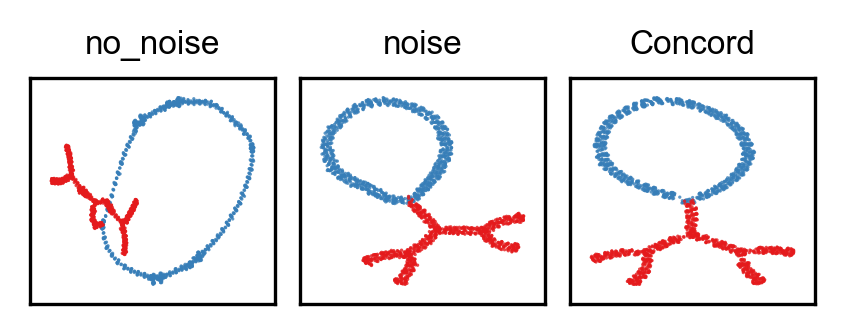

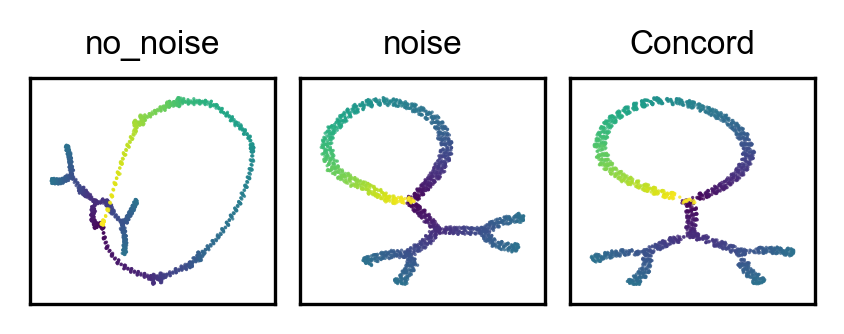

In [16]:
# plot everything
import matplotlib.pyplot as plt
import pandas as pd
combined_keys=['PCA_no_noise', 'PCA_noise', 'Concord']

# Set Arial as the default font
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

color_bys = ['structure', 'time']
basis_types = ['KNN']
#basis_types = ['PCA']
#basis_types = ['KNN']
font_size=8
point_size=2.5
alpha=0.8
figsize=(0.9*len(combined_keys),1)
ncols = len(combined_keys)
nrows = int(np.ceil(len(combined_keys) / ncols))
pal = {'time':'viridis', 'batch':'Set1'}
k=40
edges_color='grey'
edges_width=0.0
layout='kk'
threshold = 0
node_size_scale=0.1
edge_width_scale=0.1

rasterized = True
with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_all_embeddings(
        adata,
        combined_keys,
        color_bys=color_bys,
        basis_types=basis_types,
        pal=pal,
        k=k,
        edges_color=edges_color,
        edges_width=edges_width,
        layout=layout,
        threshold=threshold,
        node_size_scale=node_size_scale,
        edge_width_scale=edge_width_scale,
        font_size=font_size,
        point_size=point_size,
        alpha=alpha,
        rasterized=rasterized,
        figsize=figsize,
        ncols=ncols,
        seed=seed,
        leiden_key='leiden',
        save_dir=save_dir,
        file_suffix=file_suffix +f'rasterized_{rasterized}'+ f'ngenestraj_{N_GENES_TRAJ}_ngenestree_{N_GENES_TREE}',
        save_format='svg'
    )


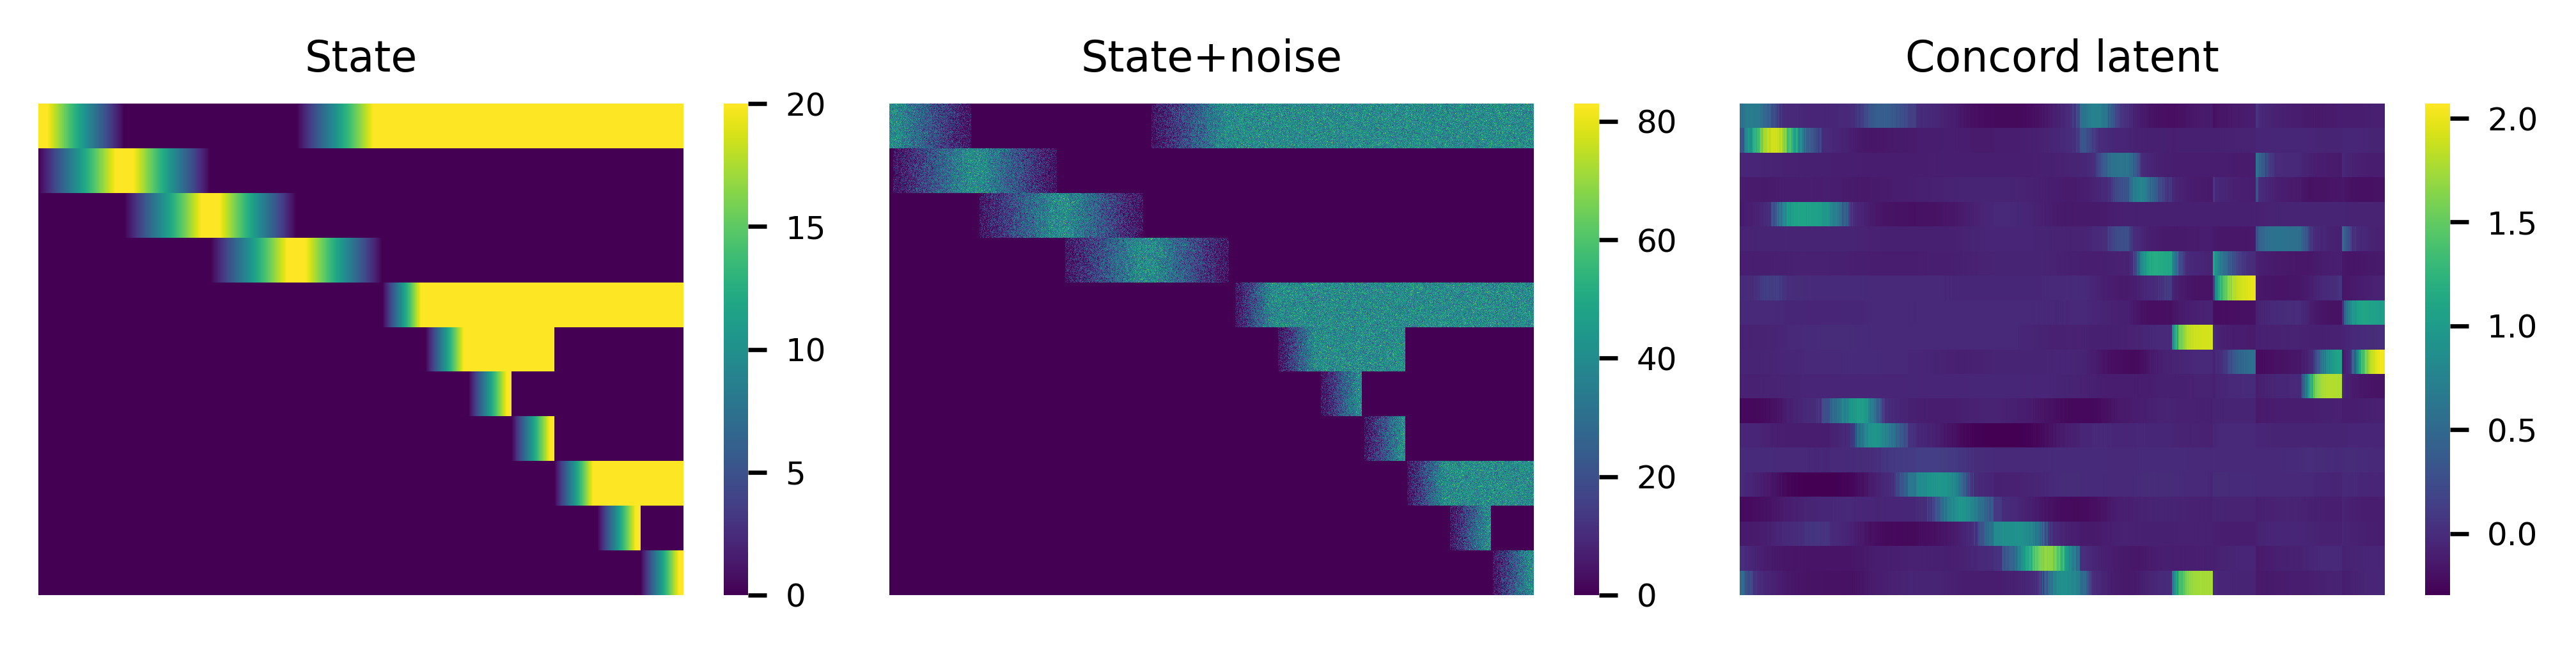

In [18]:
state_key = 'structure'
cell_order = adata.obs['time'].argsort()
_, _, _, feature_order = ccd.ul.sort_and_smooth_signal_along_path(adata, signal_key='Concord', path=cell_order, sigma=2)
adata.obsm['Concord_sorted'] = adata.obsm['Concord'][:, feature_order]
# Plot heatmap of original data and Concord latent
import matplotlib.pyplot as plt
figsize = (2.3, 1.8)
ncols = 3
title_fontsize = 8
dpi = 600
fig, axes = plt.subplots(1, ncols, figsize=(figsize[0] * ncols, figsize[1]), dpi=dpi)
ccd.pl.heatmap_with_annotations(adata, val='no_noise', obs_keys=[state_key], ax = axes[0], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
ccd.pl.heatmap_with_annotations(adata, val='X', obs_keys=[state_key], ax = axes[1], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State+noise', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
ccd.pl.heatmap_with_annotations(adata, val='Concord_sorted', obs_keys=[state_key], ax = axes[2], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Concord latent', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
plt.tight_layout(w_pad=0.0, h_pad=0.1)
plt.savefig(save_dir / f"all_heatmaps_{file_suffix}_ngenestraj_{N_GENES_TRAJ}_ngenestree_{N_GENES_TREE}.svg", dpi=dpi, bbox_inches='tight')